In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from autoencoder.supervise import equation
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})

## Plotting functions

In [2]:
# plot true and reconstructed Phi
def plot_u(Phi, u):
    """
    Samples 3 data solutions Phi and their corresponding
    reconstructed solutions u from the semantic 
    autoencoder, and plots both Phi and u
    """
    domain = np.linspace(0., 1., 100)
    num_plots = 3
    num_Phi = Phi.shape[0]
    sample_idxs = np.random.randint(0, num_Phi - 1, num_plots)
    
    fig, ax = plt.subplots(1, num_plots, figsize=(20,8), dpi=200)
    for i, s in enumerate(sample_idxs):
        ax[i].plot(domain, Phi[s], linewidth=3)
        ax[i].plot(domain, u[s], linewidth=3)
    fig.legend([r'$\Phi$', r'$u$'])
    plt.show()
    plt.close()

In [3]:
# plot true theta and learned theta
def plot_theta(theta_opt, theta):
    t_names = [r'$c$', r'$b_0$', r'$b_1$']
    num_indices = theta_opt.shape[0]
    indices = [idx + 1 for idx in range(num_indices)]
    indices = np.array(indices)
    num_plots = theta_opt.shape[1]
    
    fig, ax = plt.subplots(1, num_plots, figsize=(20,8), dpi=200)
    for i in range(num_plots):
        sort_idx = np.argsort(theta_opt[:, i])
        ax[i].scatter(indices, theta_opt[sort_idx, i])
        ax[i].scatter(indices, theta[sort_idx, i], alpha=0.4)
        ax[i].set_title(t_names[i])
    fig.legend([r'$\theta_{%s}$' % 'opt', r'$\theta$'])
    plt.show()
    plt.close()

## Load data

In [4]:
# load data
dataset = equation.Dataset('poisson')
dataset.load()
Phi_train, theta_train = dataset.train
Phi_test, theta_test = dataset.test
Phi_val, theta_val = dataset.validate

# rearrange thetas in the order (c, b0, b1)
new_order = (2, 0, 1)
theta_train = theta_train[:, new_order]
theta_test = theta_test[:, new_order]
theta_val = theta_val[:, new_order]

## Build network

In [5]:
# network parameters
tf.config.experimental_run_functions_eagerly(True)
latent_dim = 3
batch_size = 25
input_shape = (100,)
Phi = Input(shape=input_shape)

In [6]:
# encoder
x = Dense(50, 'relu', name='hidden_1')(Phi)
x = Dense(20, 'relu', name='hidden_2')(x)
theta = Dense(latent_dim, 'linear', name='theta')(x)

In [7]:
# analytic decoder
def analytic_decoder(theta):
    c, b0, b1 = tf.split(theta, 3, axis=1)
    # x and x^2
    x = np.linspace(0., 1., 100)
    x2 = x ** 2
    # -c/2 x^2
    ux2 = tf.math.divide(c, -2.)
    ux2 = tf.math.multiply(ux2, x2)
    # (c/2 + b1 - b0) x
    ux = tf.math.divide(c, 2.)
    ux = tf.math.add(ux, b1)
    ux = tf.math.subtract(ux, b0)
    ux = tf.math.multiply(ux, x)
    # b0
    u = tf.math.add(ux2, ux)
    u = tf.math.add(u, b0)
    return u

u = Lambda(analytic_decoder, name='u')(theta)

In [8]:
# compile model
sae = tf.keras.Model(Phi, u)
sae.compile('adam', 'mse')
sae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 50)                5050      
_________________________________________________________________
hidden_2 (Dense)             (None, 20)                1020      
_________________________________________________________________
theta (Dense)                (None, 3)                 63        
_________________________________________________________________
u (Lambda)                   (None, 100)               0         
Total params: 6,133
Trainable params: 6,133
Non-trainable params: 0
_________________________________________________________________


## Train and evaluate

In [9]:
# fit model
sae.fit(x=Phi_train, y=Phi_train, 
        epochs=50, 
        batch_size=batch_size, 
        verbose=0)

In [10]:
print(sae.evaluate(Phi_test, Phi_test, verbose=0))
print(sae.evaluate(Phi_val, Phi_val, verbose=0))

0.020308731123805046
0.02183379977941513


## Plots

In [11]:
# extract theta estimates
get_theta = tf.keras.Model(sae.input, sae.get_layer('theta').output)
theta_hat = get_theta(Phi_val).numpy()

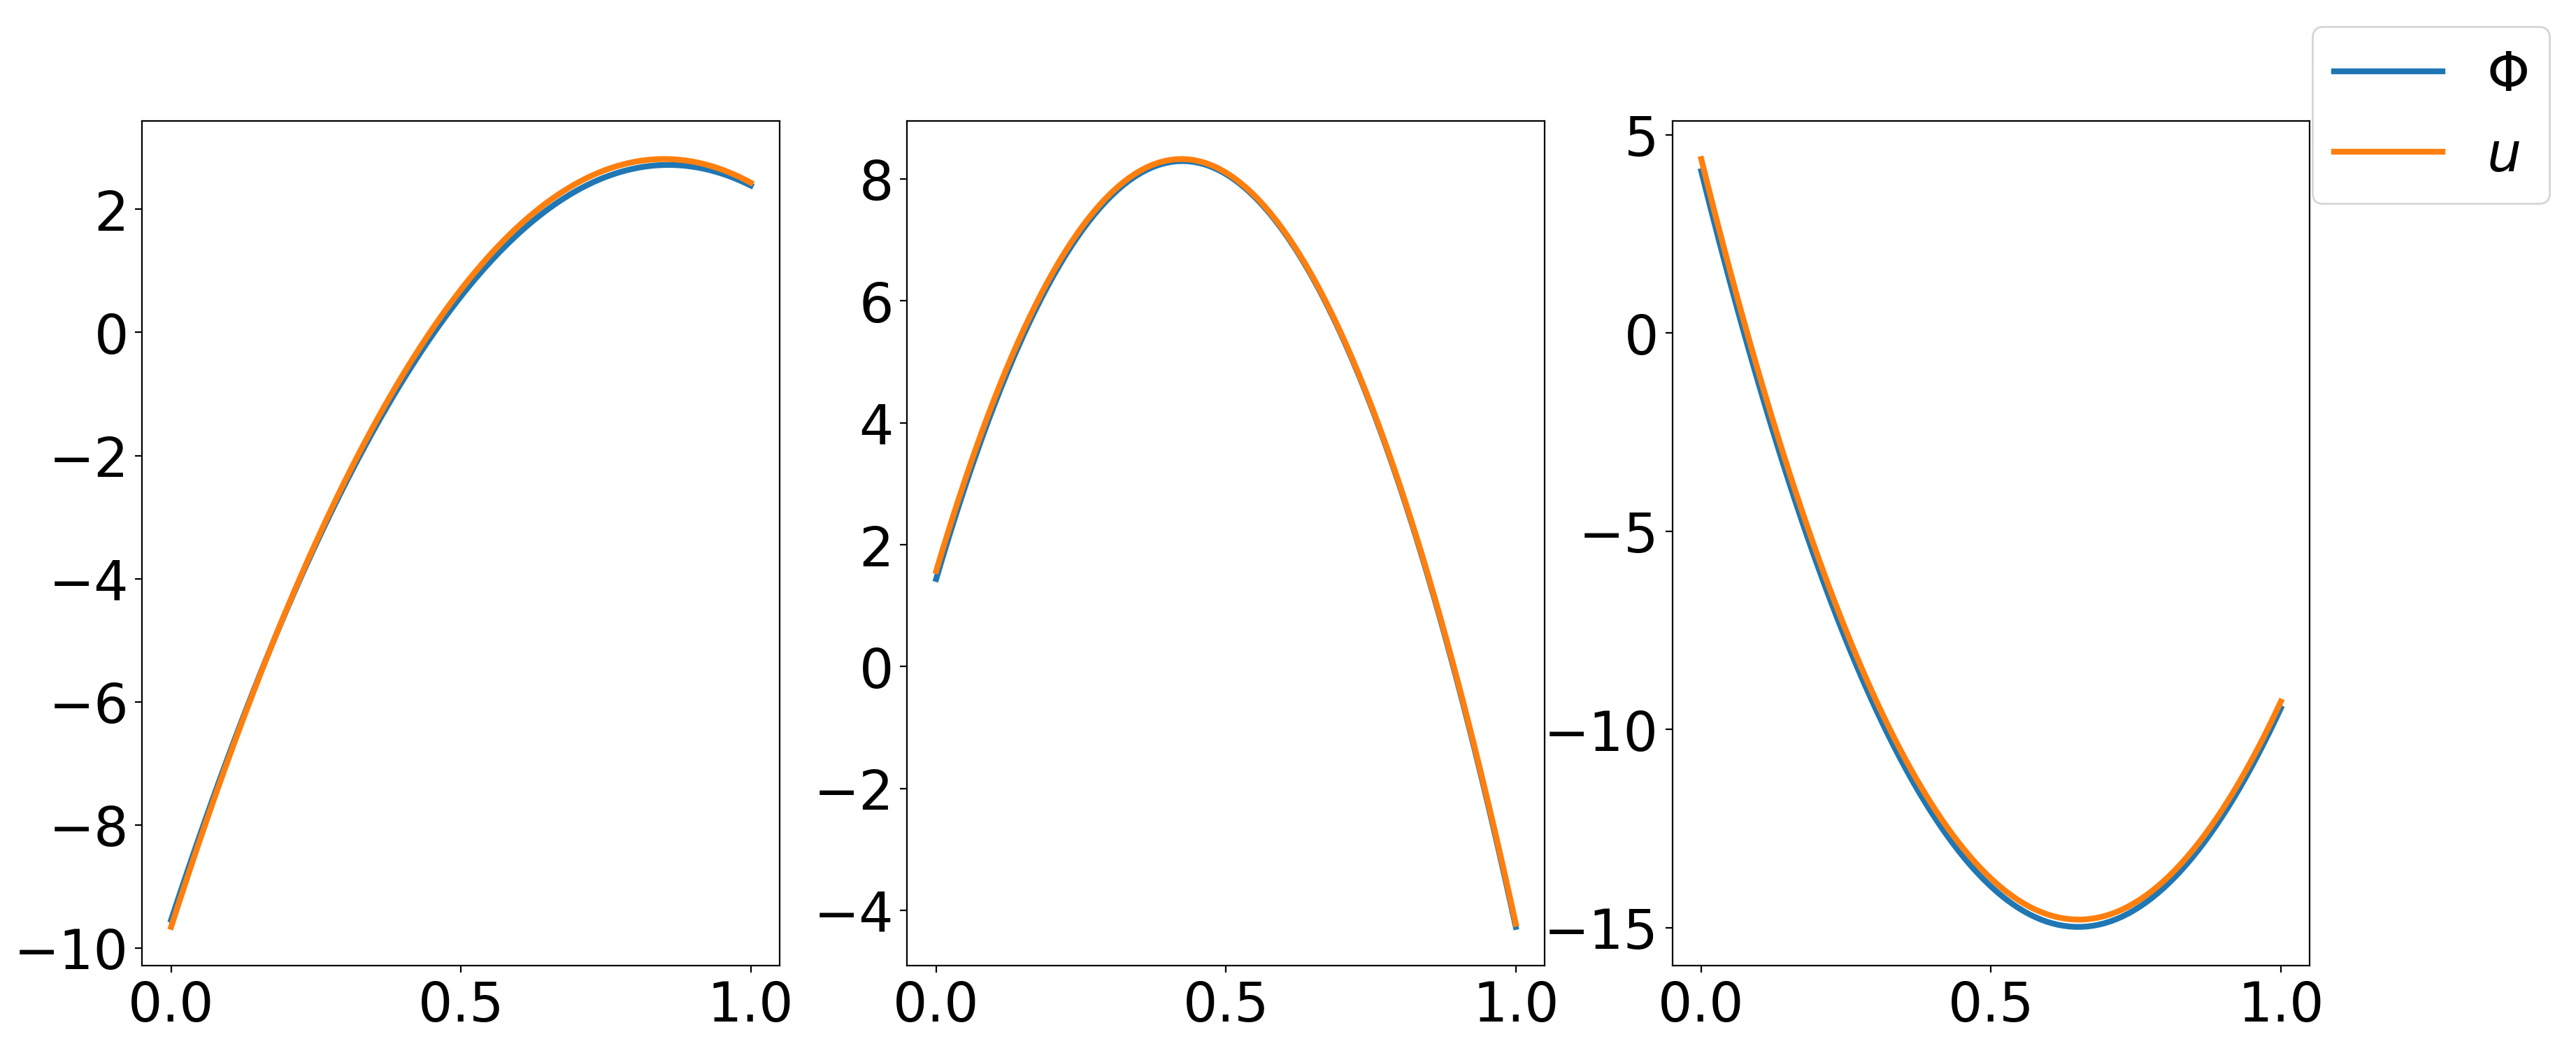

In [12]:
# validation set plots
Phi_val_hat = sae.predict(Phi_val)
plot_u(Phi_val, Phi_val_hat)

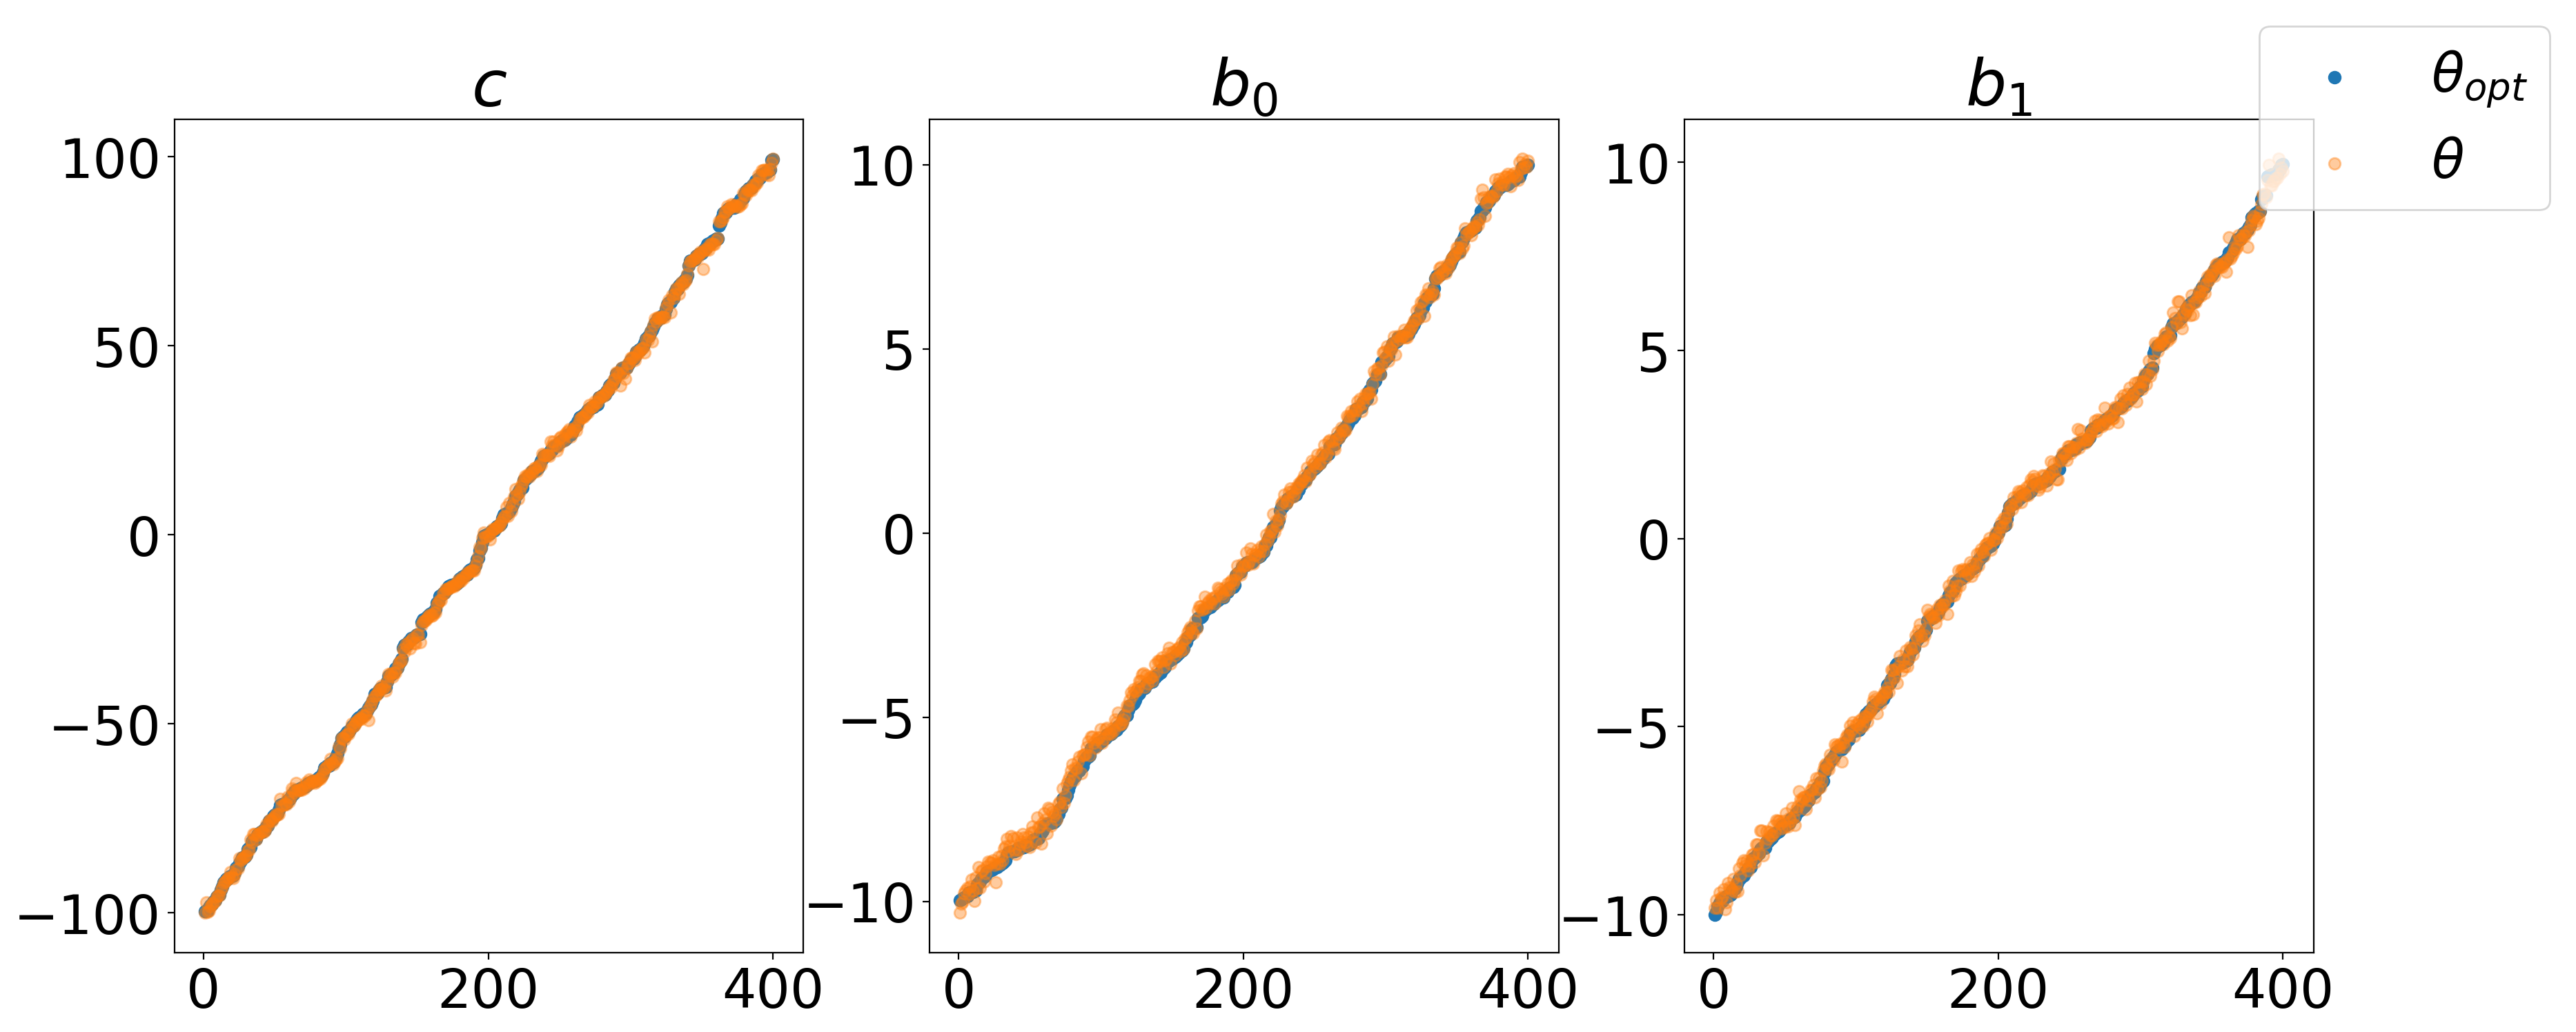

In [13]:
plot_theta(theta_val, theta_hat)

## Testing robustness

In [14]:
epsilon = np.random.randn(Phi_test.size).reshape(400, 100)
Phi_test_noisy = Phi_test + 2. * epsilon
Phi_test_noisy_hat = sae.predict(Phi_test_noisy)
theta_test_noisy_hat = get_theta(Phi_test_noisy).numpy()

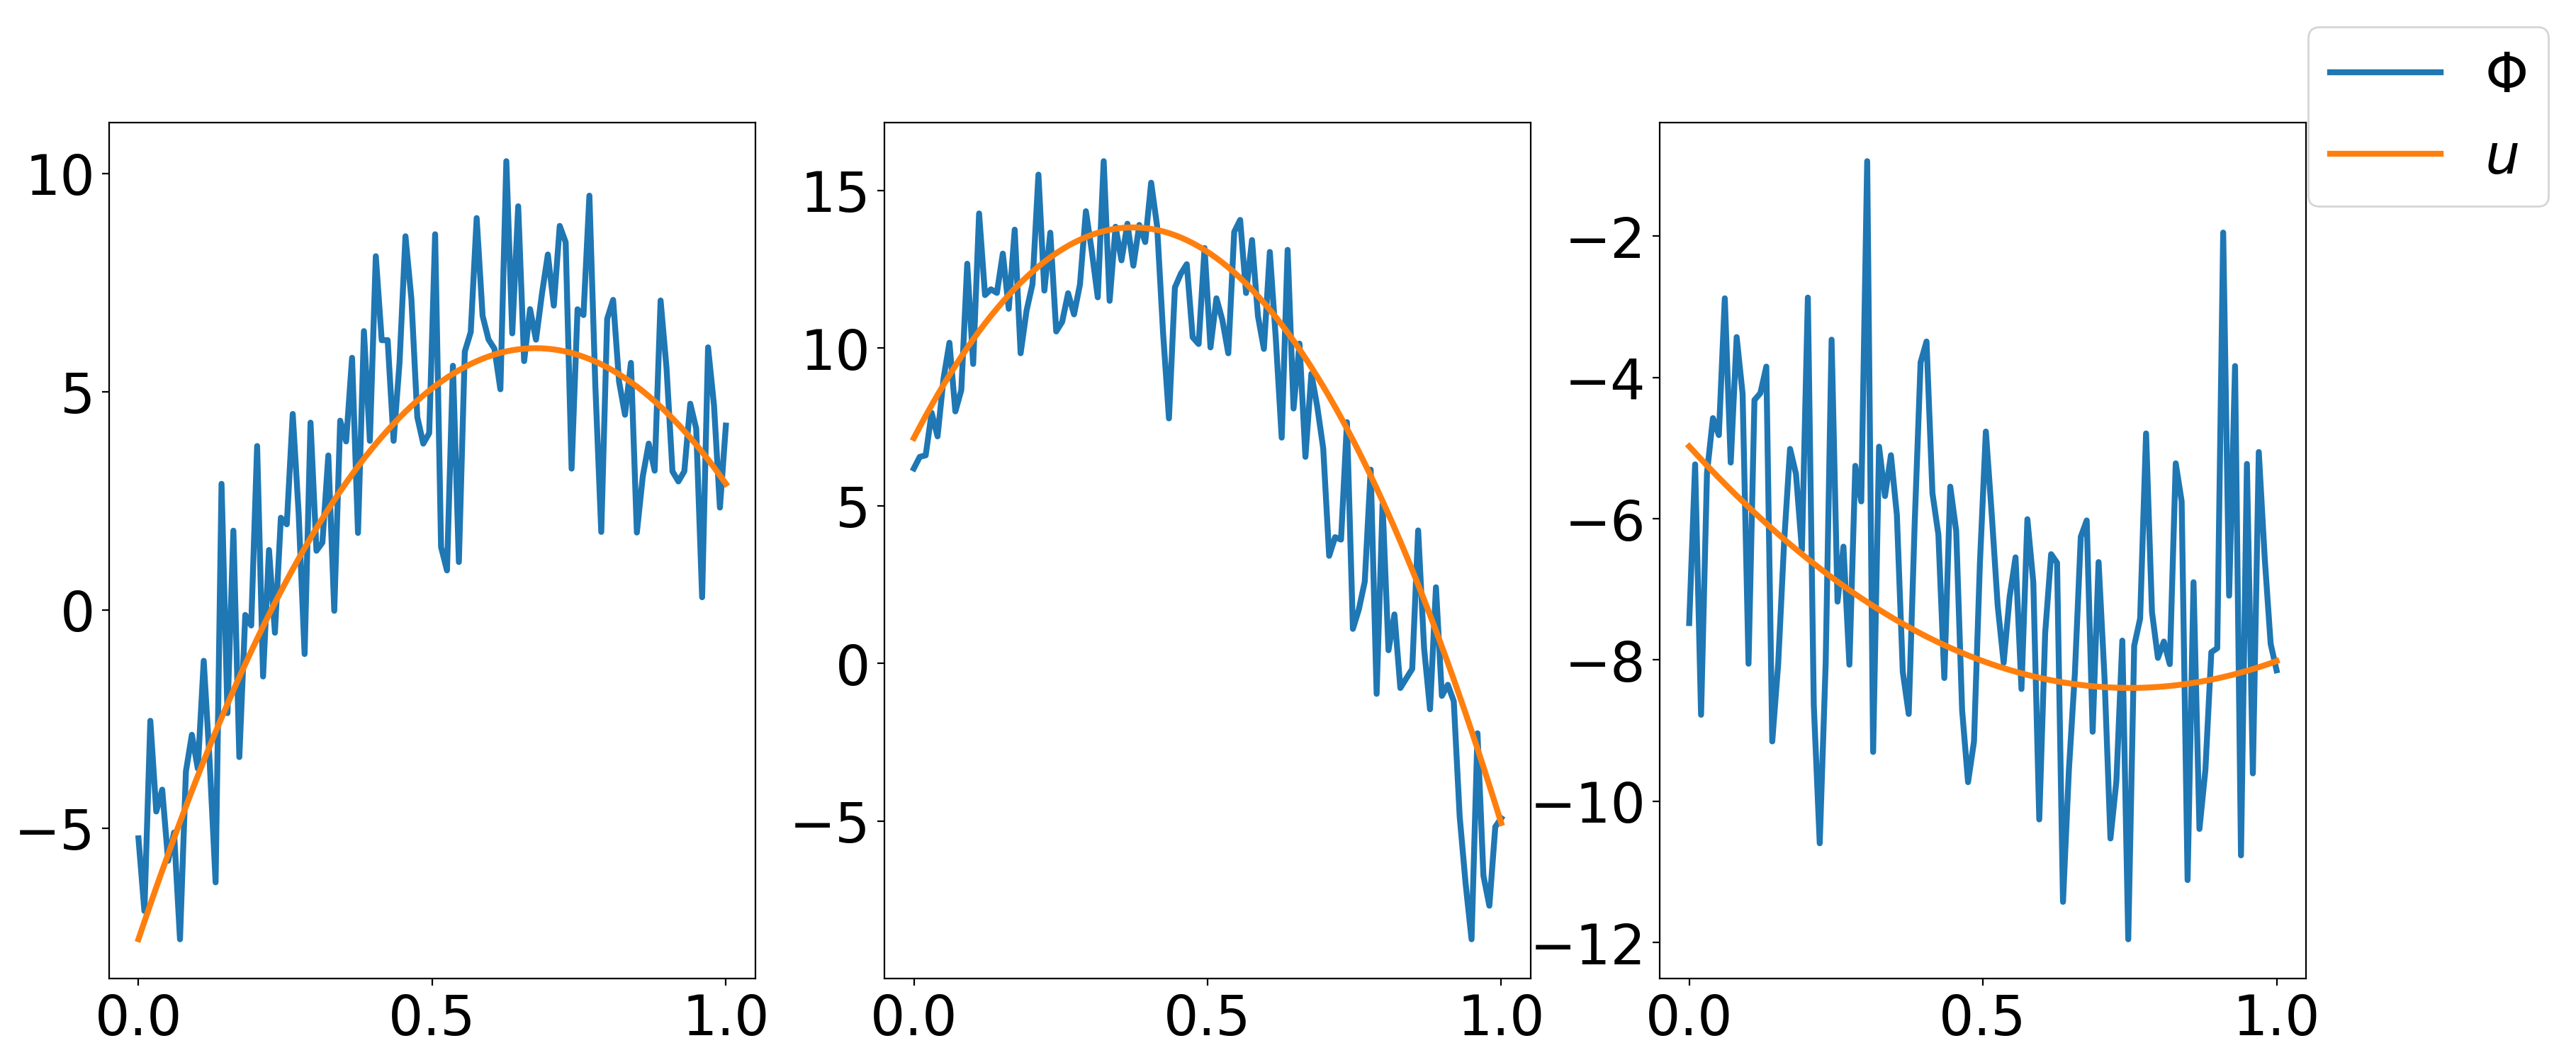

In [15]:
plot_u(Phi_test_noisy, Phi_test_noisy_hat)

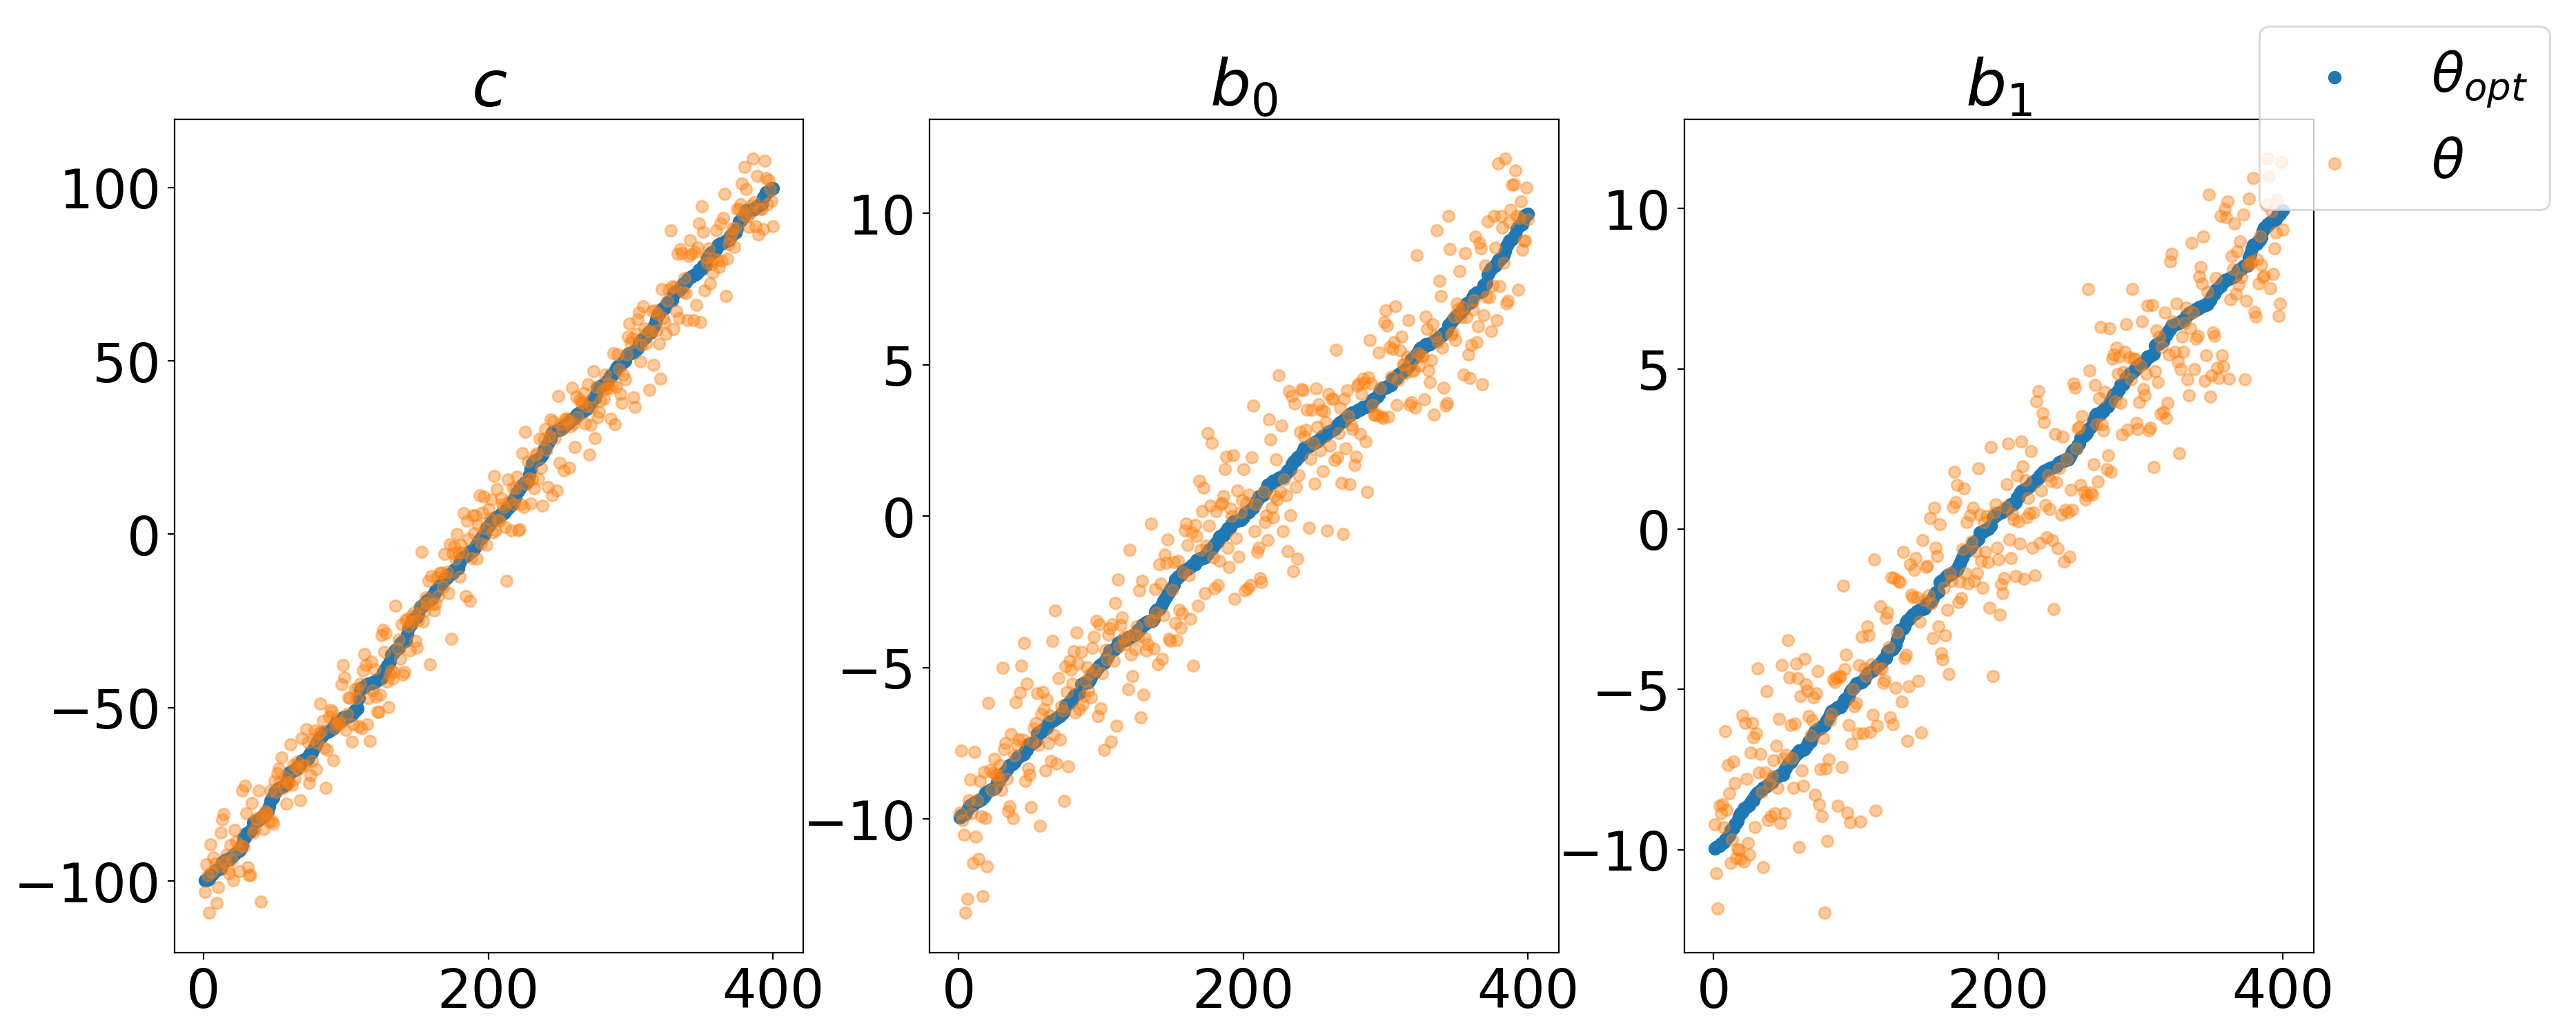

In [16]:
plot_theta(theta_test, theta_test_noisy_hat)